### Marine Heatwave Categorical Classification
Code to categorize marine heatwaves according to [Hobday et al., 2018](http://tos.org/oceanography/assets/docs/31-2_hobday.pdf).

- Categories are defined as local differences between the climatology and the 90th-percentile
- Multiples of this difference describe the different categoreis of MHWs

![MHW Ranking](Hobday_etal_2018.png)

In [189]:
import numpy as np
import os, time, datetime
from datetime import date
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series, concat
from marineHeatWaves import detect

### Data Prep
#### Load time series data from individual netCDF files

In [190]:
# Load data
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 3 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: ' + lat + 'ºN,' + lon + 'ºS')

fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path
data_files = Dataset(fp + 'sst_' + files[f]) # reading the netCDF file and creating a dataset
    
# SST (deg-C)   
SST = np.squeeze(data_files.variables['sst'][:])

# Time (days since)
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

# Dates (yyyy-mm-dd)
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)

# Create a python series
data = DataFrame(SST, columns=['SST'])

print(data.head())

Location: 50ºN,140ºS
         SST
0  14.740000
1  15.290000
2  12.349999
3  12.270000
4  12.570000


### <font color=red>Find the heatwaves</font>

- To do this we need the [marineHeatWaves](https://github.com/ecjoliver/marineHeatWaves) module created by Eric Oliver. 
- We will set our climatology to be between 1988-2017. This is the period in which we define the seasonal 90th percentile threshold to define marine heatwaves over all the data.
- We are going to require that marine heatwaves persist for at least 5-days with no more than a 2-day drop in temperature below the threshold for any given event. 

In [191]:
sst = np.array(data['SST'])
time = np.array(sst_time).astype(int)

mhw, clim = detect(time, sst, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=6, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)

sst_clim = clim['seas'] # seasonal climatology
mhw_thres = clim['thresh'] # marine heatwave threshold
mhw_st = mhw['index_start'] # Start index of MHWs
mhw_en = mhw['index_end'] # End index of MHWs

#### Find where the sea surface temperature meets our criteria for a marine heatwave

(i.e. exceeds 90th percentile threshold for at least 5 days)

number of marine heatwave days = 		828.0
percent of days considered a marine heatwave = 	0.06163924663143006


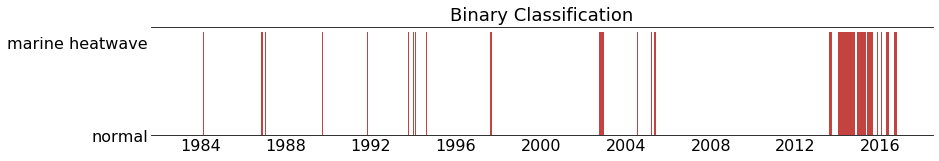

In [192]:
# create MHW labels [1=MHW, 0=normal]
mhw_label = sst * 0
for i in range(0,len(mhw_st)):
    n = mhw_en[i] - mhw_st[i]
    mhw_label[mhw_st[i]:mhw_en[i]] = np.ones(n)

    
# Plot binary classification
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.figure(figsize=(14,2))
ax = plt.subplot(111)
plt.bar(sst_dates, mhw_label, width=10, color='xkcd:reddish')
plt.yticks([0, .9], ['normal', 'marine heatwave']);
plt.title('Binary Classification', fontsize=18)
ax.get_yaxis().tick_left() 
plt.xlim((sst_dates[0], sst_dates[-1]))  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)


print('number of marine heatwave days = \t\t{}'.format(sum(mhw_label)))
print('percent of days considered a marine heatwave = \t{}'.format(sum(mhw_label)/len(mhw_label)))

### Categorical encodings for marine heatwave intensity
Label days according to categorical scheme proposed in [Hobday et al., 2018](http://tos.org/oceanography/assets/docs/31-2_hobday.pdf).

* 4 = **Extreme** (>4x threshold)
* 3 = **Severe** (3-4x threshold)
* 2 = **Strong** (2-3x threshold)
* 1 = **moderate** (1-2x threshold)
* 0 = no marine heatwave

number of marine heatwave days = 		828


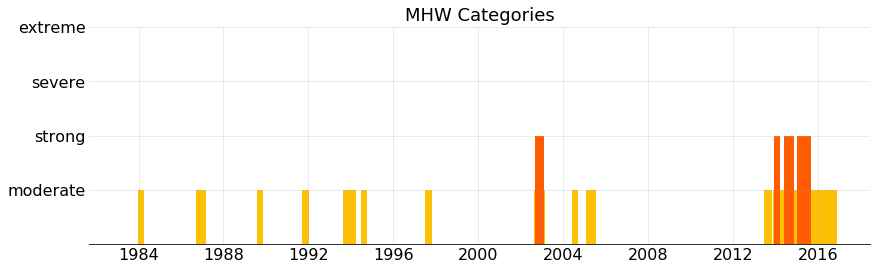

In [193]:
MH = (mhw_label==1) # index to where there are labeled marine heatwaves
print('number of marine heatwave days = \t\t{}'.format(sum(MH)))

# Find how many times the anomaly is divisable by the threshold different from the climatology
mhw_relThreshNorm = (data['SST'][MH] - clim['thresh'][MH]) / (clim['thresh'][MH] - clim['seas'][MH]) 
categsh = np.zeros(data['SST'].size) 
categsh[MH] = np.floor(1. + mhw_relThreshNorm) 

# Plot categorical encodings for marine heatwave intensity
plt.figure(figsize=(14,4))        
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
ax = plt.subplot(111)
plt.bar(sst_dates[(categsh==1)], categsh[(categsh==1)], width=100, color='xkcd:marigold')
plt.bar(sst_dates[(categsh==2)], categsh[(categsh==2)], width=100, color='xkcd:bright orange')
plt.bar(sst_dates[(categsh==3)], categsh[(categsh==3)], width=100, color='xkcd:lipstick red')
plt.bar(sst_dates[(categsh==4)], categsh[(categsh==4)], width=100, color='xkcd:reddy brown')
plt.title('MHW Categories', fontsize=18)
plt.yticks([0, 1, 2, 3, 4], ['', 'moderate','strong','severe','extreme']);
plt.grid(True, alpha = 0.3)
plt.xlim((sst_dates[0], sst_dates[-1]))  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)

### <font color=blue> Find the coldwaves </font>
- This time we will set ```coldSpells=True```
- Our climatology will again be 1988-2017. The 10th percentile will essentially be used to find the coldwaves.
- We are going to require that marine coldwaves persist for at least 5-days with no more than a 2-day gap of temperature above this threshold for any given event. 

In [194]:
sst = np.array(data['SST'])
time = np.array(sst_time).astype(int)

mcw, clim = detect(time, sst, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=6, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=True, alternateClimatology=False)

sst_clim = clim['seas'] # seasonal climatology
mcw_thres = clim['thresh'] # marine heatwave threshold
mcw_st = mcw['index_start'] # Start index of MHWs
mcw_en = mcw['index_end'] # End index of MHWs

#### Find where the sea surface temperature meets our criteria for a marine coldwaves

(i.e. below 10th percentile threshold for at least 5 days)

number of marine coldwave days = 		675.0
percent of days considered a marine coldwave = 	0.050249385840839725


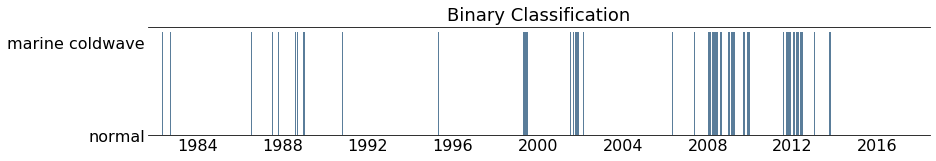

In [195]:
# create MCW labels [1=MCW, 0=normal]
mcw_label = sst * 0
for i in range(0,len(mcw_st)):
    n = mcw_en[i] - mcw_st[i]
    mcw_label[mcw_st[i]:mcw_en[i]] = np.ones(n)

    
# Plot binary classification
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.figure(figsize=(14,2))
ax = plt.subplot(111)
plt.bar(sst_dates, mcw_label, width=10, color='xkcd:steel blue')
plt.yticks([0, .9], ['normal', 'marine coldwave']);
plt.title('Binary Classification', fontsize=18)
ax.get_yaxis().tick_left() 
plt.xlim((sst_dates[0], sst_dates[-1]))  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)


print('number of marine coldwave days = \t\t{}'.format(sum(mcw_label)))
print('percent of days considered a marine coldwave = \t{}'.format(sum(mcw_label)/len(mcw_label)))

#### Categorical encodings for marine coldwave intensity

* -4 = **Extreme** (>4x threshold)
* -3 = **Severe** (3-4x threshold)
* -2 = **Strong** (2-3x threshold)
* -1 = **moderate** (1-2x threshold)
* 0 = no marine heatwave

number of marine coldwave days = 		675


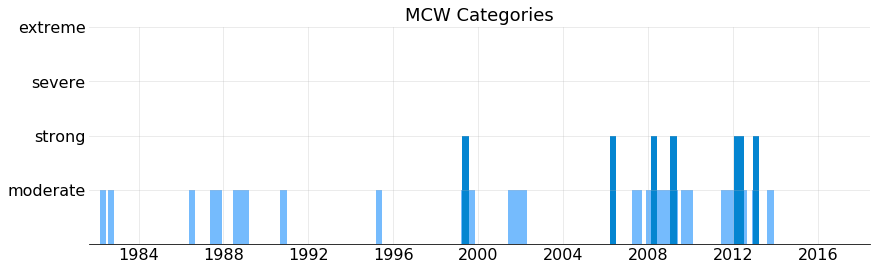

In [196]:
MC = (mcw_label==1) # index to where there are labeled marine coldwaves
print('number of marine coldwave days = \t\t{}'.format(sum(MC)))

# Find how many times the anomaly is divisable by the threshold different from the climatology
mcw_relThreshNorm = (data['SST'][MC] - clim['thresh'][MC]) / (clim['thresh'][MC] - clim['seas'][MC]) 
categsc = np.zeros(data['SST'].size) 
categsc[MC] = np.ceil(-1. - mcw_relThreshNorm) 

# Plot categorical encodings for marine coldwave intensity
plt.figure(figsize=(14,4))        
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
ax = plt.subplot(111)
plt.bar(sst_dates[(categsc==-1)], -1*categsc[(categsc==-1)], width=100, color='xkcd:sky blue')
plt.bar(sst_dates[(categsc==-2)], -1*categsc[(categsc==-2)], width=100, color='xkcd:cerulean')
plt.bar(sst_dates[(categsc==-3)], -1*categsc[(categsc==-3)], width=100, color='xkcd:grey blue')
plt.bar(sst_dates[(categsc==-4)], -1*categsc[(categsc==-4)], width=100, color='xkcd:deep blue')
plt.title('MCW Categories', fontsize=18)
plt.yticks([0, 1, 2, 3, 4], ['', 'moderate', 'strong', 'severe', 'extreme']);
plt.grid(True, alpha=0.3)
plt.xlim((sst_dates[0], sst_dates[-1]))  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)

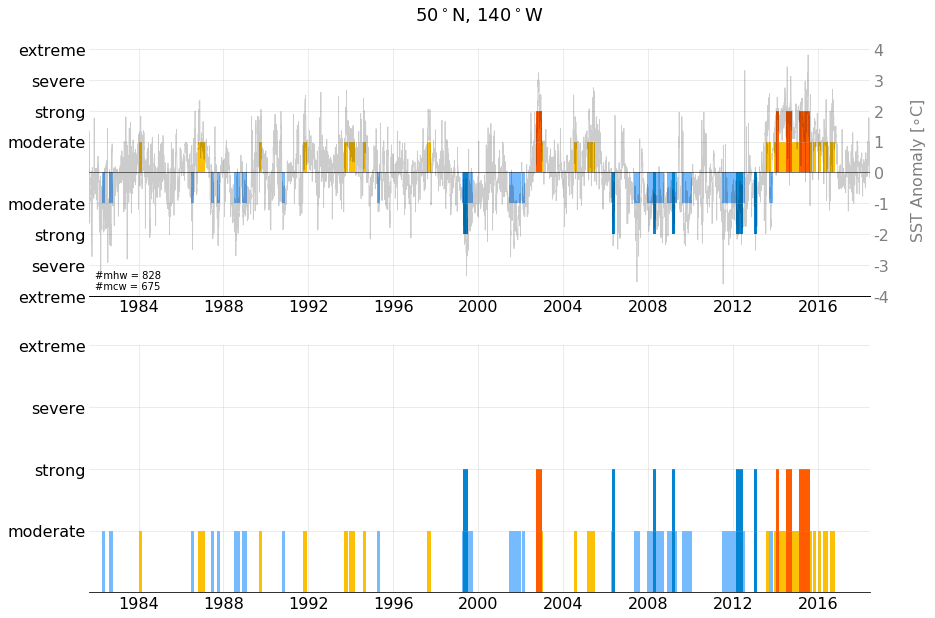

In [197]:
# Combine heatwave and coldwave labels
categ = categsh + categsc

# Plot categories for both marine heatwave and coldwave events
plt.figure(figsize=(14,10))        
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
ax = plt.subplot(211)
plt.plot(sst_dates, np.zeros(len(sst_dates)), color='k', linewidth=.5)
plt.plot(sst_dates, data['SST'] - clim['seas'], color='k', linewidth=.8, alpha=0.2)
plt.bar(sst_dates[(categ==1)], categ[(categ==1)], width=50, color='xkcd:marigold')
plt.bar(sst_dates[(categ==2)], categ[(categ==2)], width=50, color='xkcd:bright orange')
plt.bar(sst_dates[(categ==3)], categ[(categ==3)], width=50, color='xkcd:lipstick red')
plt.bar(sst_dates[(categ==4)], categ[(categ==4)], width=50, color='xkcd:reddy brown')
plt.bar(sst_dates[(categ==-1)], categ[(categ==-1)], width=50, color='xkcd:sky blue')
plt.bar(sst_dates[(categ==-2)], categ[(categ==-2)], width=50, color='xkcd:cerulean')
plt.bar(sst_dates[(categ==-3)], categ[(categ==-3)], width=50, color='xkcd:grey blue')
plt.bar(sst_dates[(categ==-4)], categ[(categ==-4)], width=50, color='xkcd:deep blue')
plt.title(lat + '$^\circ$N, ' + lon + '$^\circ$W \n', fontsize=18)
plt.grid(True, alpha=0.3)
plt.xlim((sst_dates[0], sst_dates[-1]))  
plt.ylim((-4, 4.01))  
plt.yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4], 
           ['extreme', 'severe', 'strong', 'moderate', '',
            'moderate', 'strong', 'severe', 'extreme']);
ax.set_yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
ax2 = ax.twinx()
ax2.set_ylabel('\n SST Anomaly [$\circ$C]', color='k', fontsize=16, alpha=0.5)
ax2.set_yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4], ['-4','-3','-2','-1','0','1','2','3','4'], alpha=0.5) 
plt.ylim((-4, 4.01))  
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_right() 
ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False) 
ax2.spines["left"].set_visible(False) 
ax2.tick_params(axis=u'both', which=u'both', length=0)
plt.text(sst_dates[100], -3.8, '#mhw = {}\n#mcw = {}'.format(sum(MH), sum(MC)))

# Another plot of the same thing, but different yaxis
#plt.figure(figsize=(14,3))        
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
ax = plt.subplot(212)
plt.plot(sst_dates, np.zeros(len(sst_dates)), color='k', linewidth=.5)
plt.bar(sst_dates[(categ==1)], categ[(categ==1)], width=50, color='xkcd:marigold')
plt.bar(sst_dates[(categ==2)], categ[(categ==2)], width=50, color='xkcd:bright orange')
plt.bar(sst_dates[(categ==3)], categ[(categ==3)], width=50, color='xkcd:lipstick red')
plt.bar(sst_dates[(categ==4)], categ[(categ==4)], width=50, color='xkcd:reddy brown')
plt.bar(sst_dates[(categ==-1)], -1*categ[(categ==-1)], width=50, color='xkcd:sky blue')
plt.bar(sst_dates[(categ==-2)], -1*categ[(categ==-2)], width=50, color='xkcd:cerulean')
plt.bar(sst_dates[(categ==-3)], -1*categ[(categ==-3)], width=50, color='xkcd:grey blue')
plt.bar(sst_dates[(categ==-4)], -1*categ[(categ==-4)], width=50, color='xkcd:deep blue')
plt.title('  \n ', fontsize=18)
plt.yticks([0, 1, 2, 3, 4], ['', 'moderate', 'strong', 'severe', 'extreme']);
plt.grid(True, alpha=0.3)
plt.xlim((sst_dates[0], sst_dates[-1]))  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)

| Label |Event Description | 
|:-----:|:----------------:|
|   4   | extreme heatwave |
|   3   | severe heatwave  |
|   2   | strong heatwave  |
|   1   | moderate heatwave|
|   0   | no events        |
|  -1   | moderate coldwave|
|  -2   | strong coldwave  |
|  -3   | severe coldwave  |
|  -4   | extreme coldwave |

#### Export categorical encodings to a CSV

In [198]:
import csv

fn = 'mhwcw_categories_'+files[f][:-3]+'.csv'
download_dir = '/Users/hscannell/Desktop/MHWpredict/data/Labels/'+fn 
print(download_dir)
#where you want the file to be downloaded to 

MyData = np.vstack((sst_dates, categ))

myFile = open(download_dir, "w") 

with myFile:
    
    writer = csv.writer(myFile)

    writer.writerows(MyData)
     
print("Writing complete!")

/Users/hscannell/Desktop/MHWpredict/data/Labels/mhwcw_categories_50n140w.csv
Writing complete!
